# ch 3. ARIMA

이번 챕터에서는 본격적으로 시계열 예측 모델들에 대해서 배웁니다. 그 중에서도 ARIMA는 가장 기본적인 시계열 예측 모델입니다.

In [1]:
import warnings

warnings.filterwarnings(action='ignore')

## 데이터 셋 준비

과적합 여부 파악과 성능 평가를 위해 특정 시점을 기준으로 train과 test 셋을 나누겠습니다.

In [5]:
import pandas as pd

train_df = pd.read_csv("./data/passengers_train.csv", index_col="Month", parse_dates=True)
test_df = pd.read_csv("./data/passengers_test.csv", index_col="Month", parse_dates=True)

<Axes: xlabel='Month'>

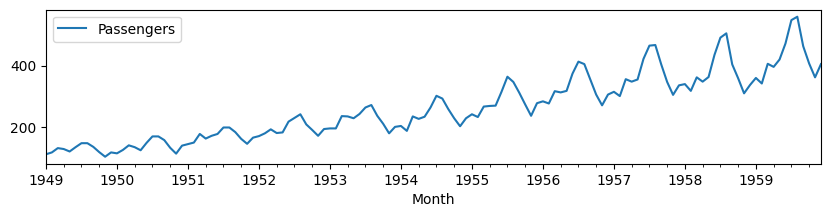

In [6]:
train_df.plot(figsize=(10, 2))

<Axes: xlabel='Month'>

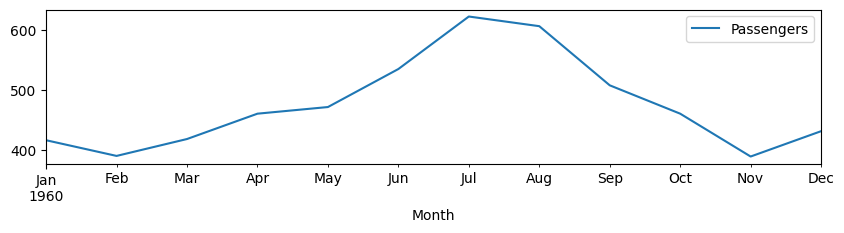

In [7]:
test_df.plot(figsize=(10, 2))

## ARIMA

ARIMA 모델은 가장 기본적인 시계열 예측 모델이며 크게 세가지 구성 요소로 이루어져 있습니다. 

- AR(Auto Regression): 현재 관측값과 이전 기간의 관측값 사이의 종속 관계를 활용하는 회귀 모델입니다.
- I(Integration):  시계열을 고정시키기 위해 관측치 차분을 사용합니다. 미분은 시계열의 현재 값에서 이전 값 d 횟수를 빼는 것을 포함합니다.
- MA(Moving Average): 잔차 오차와 관측치 간의 종속성을 사용하는 모델입니다. 이동 평균 성분은 모델의 오차를 이전 오차 항의 조합으로 나타냅니다.

ARIMA 모델을 학습시키기 위해서는 p, d, q 세가지 파라미터를 결정해야 하며, 이를 위해선 각 구성 요소들이 어떻게 동작하는지 이해해야 합니다.

### Auto Regressive

이전 시점의 값들을 feature로 사용하여 다음에 올 값을 예측하는 회귀 모델입니다. 스스로를 feature로 사용하기 때문에 auto regressive 모델이라고 부릅니다. 

$$Y_{t}=\alpha+\beta_{1}Y_{t-1}+\beta_{t-2}+...+\beta_{p}Y_{t-p}+\epsilon_{t}$$

여기서 몇번째 lag 까지를 회귀식에 포함할 지를 의미하는 p가 ARIMA 모델을 학습시키기 위해 필요한 첫번째 파라미터입니다.

간단하게 AR 모델을 학습시켜보고, 시각화해보겠습니다.

In [8]:
from statsmodels.tsa.ar_model import AutoReg 

ar_4_model = AutoReg(train_df["Passengers"], lags=4).fit()
ar_12_model = AutoReg(train_df["Passengers"], lags=12).fit()

/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [9]:
ar_4_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  132
Model:                     AutoReg(4)   Log Likelihood                -611.397
Method:               Conditional MLE   S.D. of innovations             28.720
Date:                Wed, 10 Jan 2024   AIC                           1234.794
Time:                        13:46:37   BIC                           1251.906
Sample:                    05-01-1949   HQIC                          1241.747
                         - 12-01-1959                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.3932      7.122      1.740      0.082      -1.567      26.353
Passengers.L1     1.2968      0.088     14.694      0.000       1.124       1.470
Passengers.L2    -0.4727      0.146     -3.228      0.001      -0.760      -0.186
Passengers.L3    -0.0314      0.147     -0.213      0.831      -0.319       0.257
Passengers.L4     0.1692      0.090      1.881      0.060      -0.007       0.345
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0399           -0.0000j            1.0399           -0.0000
AR.2            0.8292           -1.2548j            1.5040           -0.1571
AR.3            0.8292           +1.2548j            1.5040            0.1571
AR.4           -2.5128           -0.0000j            2.5128           -0.5000
-----------------------------------------------------------------------------
"""

In [10]:
train_df["AR 4"] = ar_4_model.predict()
train_df["AR 12"] = ar_12_model.predict()

<Axes: xlabel='Month'>

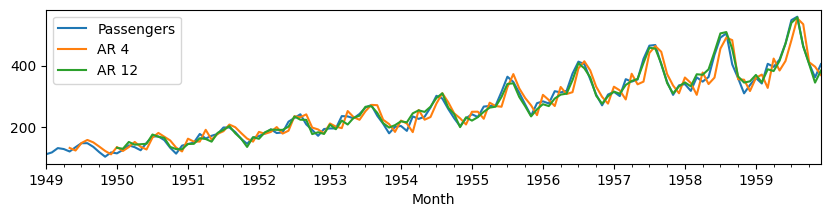

In [11]:
train_df.plot(figsize=(10, 2))

In [12]:
test_df["AR 4"] = ar_4_model.forecast(steps=len(test_df))
test_df["AR 12"] = ar_12_model.forecast(steps=len(test_df))

<Axes: xlabel='Month'>

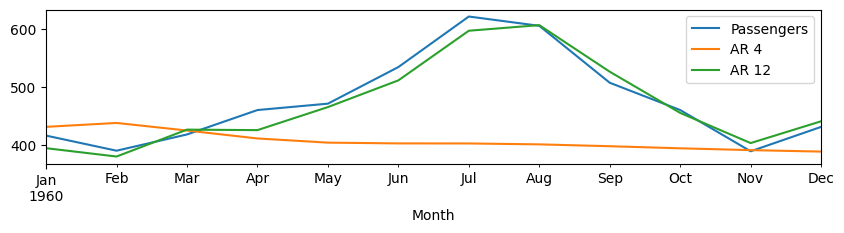

In [13]:
test_df.plot(figsize=(10, 2))

예측 결과가 얼마나 정확한지 오차를 측정해보겠습니다.

In [32]:
from sklearn.metrics import mean_squared_error 
import numpy as np

def calculate_rmse(df, label_column, pred_column):
    rmse = np.sqrt(mean_squared_error(df[label_column], df[pred_column]))
    print(f"{pred_column}: {rmse}")
    
calculate_rmse(test_df, "Passengers", "AR 4")
calculate_rmse(test_df, "Passengers", "AR 12")

AR 4: 105.76024083588153
AR 12: 17.48752763093436


### Moving Average

ARIMA 모델에서 등장하는 moving average는 이전에 직접 구해보았던 이동 평균과는 다른 개념입니다. 이는 auto regressive 모델의 예측값과 실제 값 사이의 오차를 feature로 사용하는 회귀 모델입니다. 앞서 학습시킨 auto regressive의 예측값과 실제 값 사이에 오차항을 확인해보겠습니다.

In [33]:
train_df["AR 4 err"] = train_df["Passengers"] - train_df["AR 4"]
train_df["AR 12 err"] = train_df["Passengers"] - train_df["AR 12"]

<Axes: xlabel='Month'>

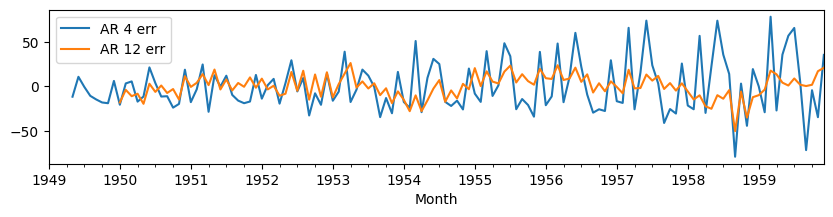

In [34]:
train_df[["AR 4 err", "AR 12 err"]].plot(figsize=(10, 2))

Moving Average는 AR 모델의 오차항들을 feature로 사용해서 예측을 하는 모델입니다. 이 때, 현재 시점으로부터 몇번째 전의 오차항까지 볼 것인지를 결정하는 파라미터가 q입니다. 

$$Y_{t}=\alpha+\epsilon_{t}+\phi_{1}\epsilon_{t-1}+\phi_{2}\epsilon_{t-2}+...+\phi_{q}\epsilon_{t-q}$$

$$\epsilon_{t}=Y_{t}-\hat{Y}_{t}$$

Moving Average 모델은 Auto Regressive 모델을 필요로 하기에, 단독으로 사용되지 않고, ARMA나 ARIMA 모델에서 AR 모델과 결합된 형태로 사용됩니다.

### ARMA

ARMA 모델은 AR 모델과 MA 모델을 단순 결합시킨 모델입니다. 이는 과거 시점의 데이터와 auto regressive 모델의 오차항을 독립 변수로 사용하는 회귀 모델입니다. 수식으로 표현하면 아래와 같습니다.

$$Y_{t}=\alpha+\beta_{1}Y_{t-1}+\beta_{t-2}Y_{t-2}+...+\beta_{p}Y_{t-p}+\epsilon_{t} +\phi_{1}\epsilon_{t-1}+\phi_{2}\epsilon_{t-2}+...+\phi_{q}\epsilon_{t-q}$$ 

이는 statsmodels에서 별도로 클래스로 제공하는 것은 없고, ARIMA 모델 생성시에 전달하는 차분 파라미터 d를 0으로 설정하면 학습시킬 수 있습니다.

### ARIMA

드디어 오늘의 주인공 ARIMA입니다. ARIMA는 차분을 적용하여 정상성을 확보한 데이터에 ARMA 모델을 학습시킨 모델입니다.

- AR: auto regressive (p)
- I: integrated (d)
- MA: Moving Average (q)

ARIMA 모델을 학습시키기 위해서는 p, q, d 세 파라미터가 필요합니다. 

- p: auto regressive 모델이 몇 lag 까지를 모델에 포함시킬 것인가
- d: 차분을 몇번 적용할 것인가
- q: moving average 모델이 몇 lag 까지를 모델에 포함시킬 것인가

여기서는 간단하게 임의의 파라미터를 지정해서 ARIMA를 학습시켜보고 결과를 시각화해보겠습니다.

In [35]:
from statsmodels.tsa.arima.model import ARIMA

arima_4_model = ARIMA(train_df["Passengers"], order=(4, 1, 2)).fit()
arima_12_model = ARIMA(train_df["Passengers"], order=(12, 1, 2)).fit()

/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provid

In [36]:
arima_4_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  132
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -612.172
Date:                Wed, 10 Jan 2024   AIC                           1238.345
Time:                        13:57:44   BIC                           1258.471
Sample:                    01-01-1949   HQIC                          1246.523
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1512      0.112      1.353      0.176      -0.068       0.370
ar.L2          0.3946      0.094      4.186      0.000       0.210       0.579
ar.L3         -0.2603      0.101     -2.587      0.010      -0.458      -0.063
ar.L4         -0.2308      0.117     -1.976      0.048      -0.460      -0.002
ma.L1          0.1307      0.097      1.352      0.176      -0.059       0.320
ma.L2         -0.7461      0.112     -6.683      0.000      -0.965      -0.527
sigma2       661.5314     88.757      7.453      0.000     487.570     835.493
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 2.34
Prob(Q):                              0.67   Prob(JB):                         0.31
Heteroskedasticity (H):               6.01   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
train_df["ARIMA 4"] = arima_4_model.predict()
train_df["ARIMA 12"] = arima_12_model.predict()

<Axes: xlabel='Month'>

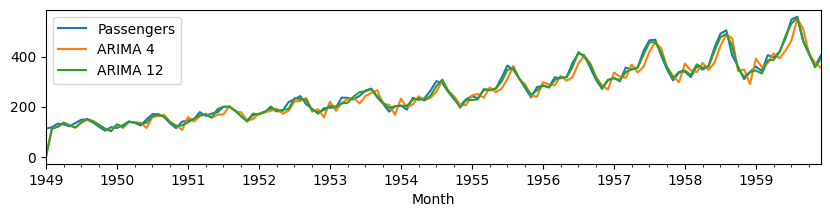

In [38]:
train_df[["Passengers", "ARIMA 4", "ARIMA 12"]].plot(figsize=(10, 2))

In [39]:
test_df["ARIMA 4"] = arima_4_model.forecast(steps=len(test_df))
test_df["ARIMA 12"] = arima_12_model.forecast(steps=len(test_df))

<Axes: xlabel='Month'>

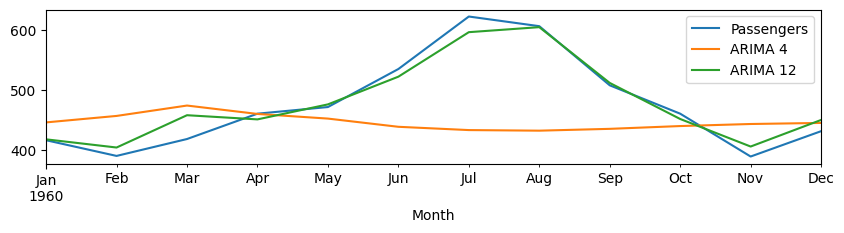

In [40]:
test_df[["Passengers", "ARIMA 4", "ARIMA 12"]].plot(figsize=(10, 2))

AR 모델과 ARIMA 모델의 성능을 측정해보겠습니다.

In [41]:
calculate_rmse(test_df, "Passengers", "AR 4")
calculate_rmse(test_df, "Passengers", "AR 12")
calculate_rmse(test_df, "Passengers", "ARIMA 4")
calculate_rmse(test_df, "Passengers", "ARIMA 12")

AR 4: 105.76024083588153
AR 12: 17.48752763093436
ARIMA 4: 87.55298319073208
ARIMA 12: 16.8564976417275


## 정리

이번 챕터에서는 기본적인 시계열 예측 모델인 ARIMA에 대해서 배워보았습니다. 그리고 ARIMA 모델을 학습시키기 위해서 필요한 파라미터 p, d, q에 대해서 알아보았고, 임의의 파라미터를 지정해서 모델을 학습시키고 결과를 확인해보았습니다. p, d, q 파라미터를 결정하기 위해서는 ACF, PACF 플랏을 보고, 복잡한 규칙을 적용해서 결정해야 합니다만, 생략하겠습니다.

ARIMA를 발전시킨 ARIMA 계열의 알고리즘들도 많이 존재합니다.
- SARIMA: 계절성을 반영한 ARIMA
- SARIMAX: 계절성과 외생 변수를 함께 고려한 ARIMA
- VAR: 여러 시계열 데이터를 한번에 고려한 ARIMA
- VARX: 여러 시계열 데이터와 외생변수를 고려한 ARIMA

그러나 이론들이 지나치게 복잡하고, 파라미터의 영향을 많이 받으며, 파라미터의 설정이 까다로워서 활용도가 높지 않습니다. (그리고 무엇보다 잘 안맞습니다 ㅎㅎ) 때문에 ARIMA 계열 알고리즘들을 더 깊게파기 보다는, 메타에서 새롭게 공개한 prophet 라이브러리를 익혀보고자 합니다.